In [1]:
import matplotlib.pyplot as plt
import numpy as np 
import os
import pandas as pd

from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Rescaling
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array,load_img
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from IPython.display import Image, display

from sklearn.model_selection import train_test_split

In [3]:
#Get Data From Zip
#!unzip COVID-19_Radiography_Dataset.zip

In [4]:
import shutil

In [5]:
#Remove Masks in Datasets https://pynative.com/python-delete-files-and-directories/#h-delete-a-non-empty-directory-using-shutil
classes = ['COVID','Lung_Opacity','Normal','Viral Pneumonia']
for i in classes:
  shutil.rmtree(f'/content/COVID-19_Radiography_Dataset/{i}/masks')


In [6]:
train_ds = image_dataset_from_directory(
    directory = '/content/COVID-19_Radiography_Dataset',
    image_size=(256,256),
    batch_size=32,
    seed=42,
    validation_split=0.1,
    shuffle = True,
    subset='training',
)
val_ds = image_dataset_from_directory(
    directory = '/content/COVID-19_Radiography_Dataset',
    image_size=(256,256),
    batch_size=32,
    seed=42,
    validation_split=0.1,
    shuffle = True,
    subset='validation',
)

Found 21165 files belonging to 4 classes.
Using 19049 files for training.
Found 21165 files belonging to 4 classes.
Using 2116 files for validation.


In [7]:
from collections import Counter

In [8]:
train_ds.class_names

['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']

In [9]:
class_names = train_ds.class_names

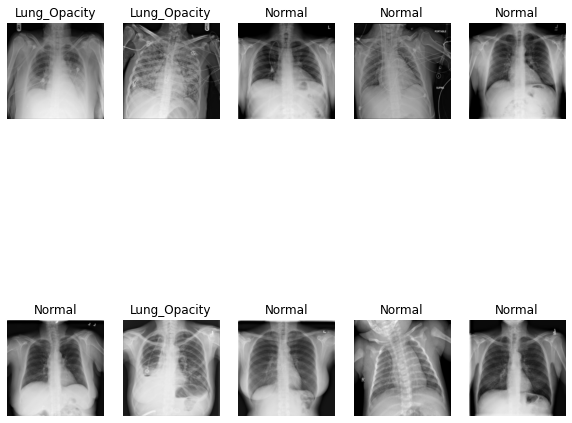

In [10]:
#How to read in images https://www.tensorflow.org/tutorials/load_data/images
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(10):
    ax = plt.subplot(2,5, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis('off')

# Modelling

In [11]:
from tensorflow.keras.regularizers import l2

In [12]:
es = EarlyStopping(patience = 5)

In [13]:
model = Sequential()
model.add(Rescaling(1./255,input_shape = (256,256,3)))
model.add(Conv2D(16,3,padding='same',activation = 'relu'))
model.add(MaxPooling2D())

model.add(Conv2D(32, 3, padding='same', activation='relu'),)
model.add(MaxPooling2D())

model.add(Conv2D(64, 3, padding='same', activation='relu'),)
model.add(MaxPooling2D())
model.add(Dropout(0.35))

model.add(Conv2D(64, 3, padding='same', activation='relu'),)
model.add(MaxPooling2D())

model.add(Flatten())
model.add(Dense(128,activation = 'relu',kernel_regularizer = l2(0.001)))
model.add(Dense(4,activation='softmax'))

# Had an error of None,1 not matching None,4, image_from_directory returns the output as a sparse matrix
# credits to https://www.kaggle.com/general/197993
model.compile(optimizer ='adam',loss ='sparse_categorical_crossentropy',metrics =['acc'])

In [14]:
h = model.fit(train_ds,validation_data = val_ds, epochs = 20,batch_size = 64,callbacks = [es])

Epoch 1/20
596/596 [==============================] - 60s 84ms/step - loss: 0.7156 - acc: 0.7478 - val_loss: 0.5547 - val_acc: 0.8119
Epoch 2/20
596/596 [==============================] - 51s 84ms/step - loss: 0.4823 - acc: 0.8482 - val_loss: 0.4716 - val_acc: 0.8459
Epoch 3/20
596/596 [==============================] - 49s 81ms/step - loss: 0.4142 - acc: 0.8742 - val_loss: 0.4487 - val_acc: 0.8544
Epoch 4/20
596/596 [==============================] - 51s 84ms/step - loss: 0.3803 - acc: 0.8869 - val_loss: 0.4558 - val_acc: 0.8578
Epoch 5/20
596/596 [==============================] - 49s 82ms/step - loss: 0.3488 - acc: 0.8989 - val_loss: 0.4030 - val_acc: 0.8767
Epoch 6/20
596/596 [==============================] - 49s 81ms/step - loss: 0.3234 - acc: 0.9094 - val_loss: 0.3898 - val_acc: 0.8866
Epoch 7/20
596/596 [==============================] - 50s 84ms/step - loss: 0.3088 - acc: 0.9150 - val_loss: 0.3762 - val_acc: 0.8894
Epoch 8/20
596/596 [==============================] - 49s 81ms

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        1

In [16]:
h.history['acc'][-1], h.history['val_acc'][-1]

(0.956270694732666, 0.8870510458946228)

# Grad Cam
Gradient Cam Keras Tutorial https://keras.io/examples/vision/grad_cam/


In [17]:
from tensorflow.keras.models import Model
import tensorflow as tf

In [18]:
list_img_paths = ['/content/COVID-19_Radiography_Dataset/COVID/images/COVID-1004.png',
                  '/content/COVID-19_Radiography_Dataset/Lung_Opacity/images/Lung_Opacity-1002.png',
                  '/content/COVID-19_Radiography_Dataset/Viral Pneumonia/images/Viral Pneumonia-1008.png',
                  '/content/COVID-19_Radiography_Dataset/Normal/images/Normal-10007.png']

In [19]:
from tensorflow import keras


In [20]:
model_builder = keras.applications.xception.Xception
img_size = (299, 299)
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions
imag = []

In [21]:
last_conv_layer_name = "block14_sepconv2_act"

In [22]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [23]:
processed_images_grad = []
for i in list_img_paths:
  img_array = preprocess_input(get_img_array(i, size=img_size))

  # Make model
  model = model_builder(weights="imagenet")

  # Remove last layer's softmax
  model.layers[-1].activation = None

  # Print what the top predicted class is
  preds = model.predict(img_array)
  print("Predicted:", decode_predictions(preds, top=1)[0])

  # Generate class activation heatmap
  heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
  processed_images_grad.append(heatmap)

35363/35363 [==============================] - 0s 0us/step
Predicted: [('n03388043', 'fountain', 7.4736013)]
1/1 [==============================] - 1s 634ms/step
Predicted: [('n03868863', 'oxygen_mask', 5.3200383)]
1/1 [==============================] - 1s 644ms/step
Predicted: [('n03868863', 'oxygen_mask', 5.548243)]
1/1 [==============================] - 1s 639ms/step
Predicted: [('n01910747', 'jellyfish', 5.0349793)]


In [24]:
import cv2

In [25]:
import matplotlib.cm as cm


In [26]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))


    imag.append(cv2.imread(img_path))
    imag.append(cv2.imread("./cam.jpg"))




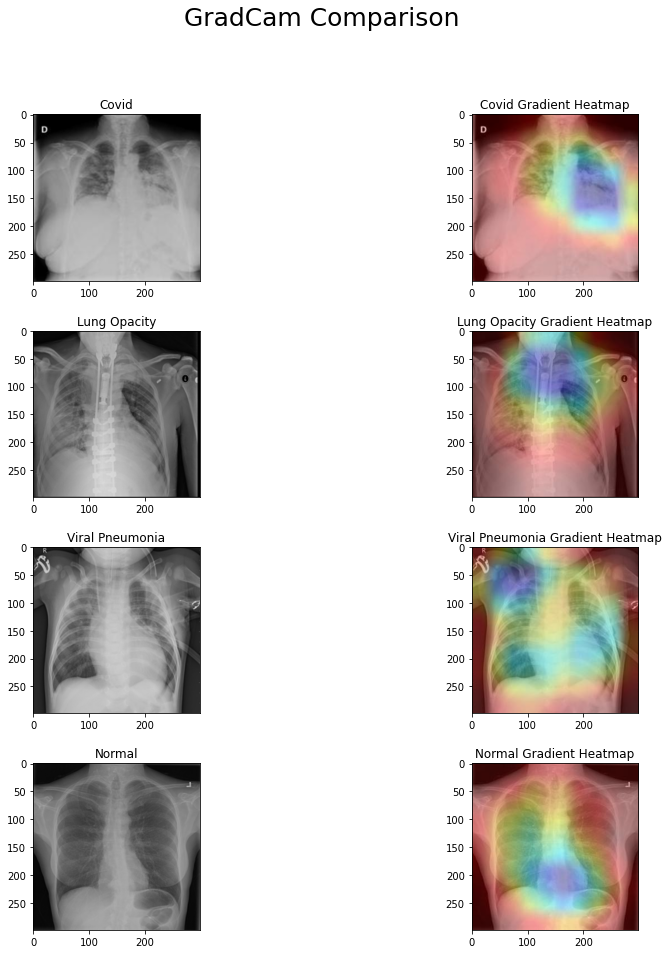

In [71]:
titles = ['Covid','Covid Gradient Heatmap','Lung Opacity','Lung Opacity Gradient Heatmap','Viral Pneumonia','Viral Pneumonia Gradient Heatmap','Normal','Normal Gradient Heatmap']
# subplot syntax https://www.geeksforgeeks.org/how-to-set-the-spacing-between-subplots-in-matplotlib-in-python/
fig,axs = plt.subplots(4,2, figsize = (15,15),squeeze = False)
fig.suptitle("GradCam Comparison",fontsize = 25)
fig.subplots_adjust(wspace= 0.1,hspace = 0.3)
for i,(img,title) in enumerate(zip(imag,titles)):
      axs[i//2,i%2].imshow(img)
      axs[i//2,i%2].set_title(title)

# Pytorch
Why pytorch? One useful feature that pytorch implemented in it is data augmentation.

# Data Augmentation
https://neptune.ai/blog/data-augmentation-in-python